#Структура и зависимости

In [1]:
!pip -q install pandas numpy pandera scikit-learn matplotlib seaborn joblib mlflow fastapi uvicorn[standard] great_expectations pytest requests dvc[gdrive] black flake8


In [2]:
!mkdir -p credit-scoring-model/data/raw
!mkdir -p credit-scoring-model/data/processed
!mkdir -p credit-scoring-model/data/expectations
!mkdir -p credit-scoring-model/models
!mkdir -p credit-scoring-model/notebooks
!mkdir -p credit-scoring-model/src/data
!mkdir -p credit-scoring-model/src/features
!mkdir -p credit-scoring-model/src/models
!mkdir -p credit-scoring-model/src/api
!mkdir -p credit-scoring-model/tests
!mkdir -p credit-scoring-model/.github/workflows
!touch credit-scoring-model/src/__init__.py
!touch credit-scoring-model/src/data/__init__.py
!touch credit-scoring-model/src/features/__init__.py
!touch credit-scoring-model/src/models/__init__.py
!touch credit-scoring-model/src/api/__init__.py

In [3]:
import json
import os
from typing import Any, Dict, Optional, Tuple

import joblib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import pandera.pandas as pa
import pytest
import requests
from fastapi import FastAPI
from pandera import Check, Column, DataFrameSchema
from pydantic import BaseModel
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from src.data.validation import validate_df
from src.features.build_features import add_features
from src.models.pipeline import make_preprocessor

ModuleNotFoundError: No module named 'src'

pytest будет запускаться и видеть src.* (созданно из-за ошибок с pandera )

In [ ]:
import os
os.environ["DISABLE_PANDERA_IMPORT_WARNING"] = "True"
print("ok")

In [ ]:
%%writefile credit-scoring-model/pytest.ini
[pytest]
pythonpath = .
testpaths = tests
addopts = -q

создаём директории по рекомендуемой архитектуре из ТЗ

In [ ]:
!cp UCI_Credit_Card.csv credit-scoring-model/data/raw/UCI_Credit_Card.csv
!ls -lah credit-scoring-model/data/raw | head


исходный CSV в “raw”

#Валидация данных Great Expectations

src/data/validation.py

In [ ]:
%%writefile credit-scoring-model/src/data/validation.py

TARGET_COL = "default.payment.next.month"


def build_schema() -> DataFrameSchema:
    schema = DataFrameSchema(
        {
            "LIMIT_BAL": Column(float, Check.ge(0), nullable=False, coerce=True),
            "AGE": Column(int, Check.in_range(18, 100), nullable=False, coerce=True),
            "SEX": Column(int, Check.isin([1, 2]), nullable=False, coerce=True),
            "EDUCATION": Column(int, Check.in_range(0, 6), nullable=False, coerce=True),
            "MARRIAGE": Column(int, Check.in_range(0, 3), nullable=False, coerce=True),
            TARGET_COL: Column(int, Check.isin([0, 1]), nullable=False, coerce=True),
        },
        strict=False,
        coerce=True,
    )
    return schema


def validate_df(df: pd.DataFrame) -> None:
    schema = build_schema()
    schema.validate(df)

- набор правил (suite) в JSON

- валидирует входной DataFrame

- ошибка если проверки провалились

In [ ]:
%%writefile credit-scoring-model/tests/test_validation.py

def test_validation_fails_on_bad_target():
    df = pd.DataFrame({
        "LIMIT_BAL": [10000, 20000],
        "AGE": [30, 40],
        "SEX": [1, 2],
        "EDUCATION": [1, 2],
        "MARRIAGE": [1, 2],
        "default.payment.next.month": [0, 2],  # 2 - нельзя
    })

    with pytest.raises(Exception):
        validate_df(df)

#Подготовка данных + Feature Engineering

src/features/build_features.py

In [ ]:
%%writefile credit-scoring-model/src/features/build_features.py


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # бин возраста
    bins = [0, 25, 35, 45, 55, 65, 200]
    labels = ["<25", "25-35", "35-45", "45-55", "55-65", "65+"]
    df["AGE_BIN"] = pd.cut(df["AGE"], bins=bins, labels=labels, include_lowest=True)

    pay_cols = [c for c in df.columns if c.startswith("PAY_")]
    bill_cols = [c for c in df.columns if c.startswith("BILL_AMT")]
    payamt_cols = [c for c in df.columns if c.startswith("PAY_AMT")]

    # в датасете есть PAY_0 - PAY_6
    if len(pay_cols) > 0:
        df["PAY_mean"] = df[pay_cols].mean(axis=1)
        df["PAY_max"] = df[pay_cols].max(axis=1)
        df["PAY_late_cnt"] = (df[pay_cols] > 0).sum(axis=1)

    if len(bill_cols) > 0:
        df["BILL_sum"] = df[bill_cols].sum(axis=1)
        df["BILL_mean"] = df[bill_cols].mean(axis=1)

    if len(payamt_cols) > 0:
        df["PAYAMT_sum"] = df[payamt_cols].sum(axis=1)
        df["PAYAMT_mean"] = df[payamt_cols].mean(axis=1)

    # отношение платежей к счетам (может быть >1)
    if "PAYAMT_sum" in df.columns and "BILL_sum" in df.columns:
        denom = df["BILL_sum"].replace(0, np.nan)
        df["PAY_to_BILL_ratio"] = (df["PAYAMT_sum"] / denom).fillna(0.0)

    return df

добавляем новые признаки чтобы показать feature engineering

src/data/make_dataset.py

In [ ]:
%%writefile credit-scoring-model/src/data/make_dataset.py


def load_raw(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # иногда в UCI версии есть колонка ID — не всегда нужна
    if "ID" in df.columns:
        df = df.drop(columns=["ID"])

    return df


def main(
    raw_path: str = "data/raw/UCI_Credit_Card.csv",
    out_dir: str = "data/processed",
    test_size: float = 0.2,
    random_state: int = 42,
):
    os.makedirs(out_dir, exist_ok=True)

    df = load_raw(raw_path)

    # Валидация "как есть", до фичей
    validate_df(df)

    # Feature Engineering
    df2 = add_features(df)

    # target
    y_col = "default.payment.next.month"
    X = df2.drop(columns=[y_col])
    y = df2[y_col].astype(int)

    # стратификация для бинарки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    train_df = X_train.copy()
    train_df[y_col] = y_train.values

    test_df = X_test.copy()
    test_df[y_col] = y_test.values

    train_path = os.path.join(out_dir, "train.csv")
    test_path = os.path.join(out_dir, "test.csv")

    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)

    print("Saved:", train_path, test_path)
    print("Train shape:", train_df.shape, "Test shape:", test_df.shape)


if __name__ == "__main__":
    main()

грузим raw

валидируем GE

строим фичи

делим на train/test

сохраняем processed CSV

запускаем prepare-stage локально в Colab
-

In [ ]:
!cd credit-scoring-model && python -m src.data.make_dataset
!ls -lah credit-scoring-model/data/processed | head

In [ ]:
!cd credit-scoring-model && pytest -q

#Pipeline модели + GridSearch + метрики + ROC

src/models/pipeline.py

создаём препроцессор (числа + категории), чтобы потом оборачивать в общий pipeline

In [ ]:
%%writefile credit-scoring-model/src/models/pipeline.py



def make_preprocessor(numeric_features, categorical_features):
    num_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    cat_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_features),
            ("cat", cat_pipe, categorical_features),
        ]
    )
    return pre

src/models/train.py (MLflow + 5 экспериментов + ROC)

обучаеи 5 моделей/настроек и логируем каждую в MLflow

метрики (ROC-AUC, Precision, Recall, F1)

рисуем ROC-кривую

выбираем лучшую по ROC-AUC

пишем metrics.json

In [ ]:
%%writefile credit-scoring-model/src/models/train.py


TARGET_COL = "default.payment.next.month"


def detect_feature_types(df: pd.DataFrame):
    numeric = []
    categorical = []
    for c in df.columns:
        if c == TARGET_COL:
            continue
        if str(df[c].dtype) in ["object", "category"]:
            categorical.append(c)
        else:
            numeric.append(c)
    return numeric, categorical


def eval_and_save_roc(y_true, y_proba, out_path: str):
    fig = plt.figure()
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title("ROC curve")
    plt.grid(True)
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)


def train_one_model(train_df, test_df, model_name: str, model, param_grid: dict, run_name: str):
    X_train = train_df.drop(columns=[TARGET_COL])
    y_train = train_df[TARGET_COL].astype(int)

    X_test = test_df.drop(columns=[TARGET_COL])
    y_test = test_df[TARGET_COL].astype(int)

    numeric_features, categorical_features = detect_feature_types(train_df)

    pre = make_preprocessor(numeric_features, categorical_features)

    pipe = Pipeline(steps=[
        ("preprocessor", pre),
        ("classifier", model),
    ])

    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring="roc_auc",
        verbose=0
    )

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("model_name", model_name)

        gs.fit(X_train, y_train)

        best = gs.best_estimator_
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric("cv_best_roc_auc", float(gs.best_score_))

        y_proba = best.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        roc_auc = roc_auc_score(y_test, y_proba)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        mlflow.log_metric("test_roc_auc", float(roc_auc))
        mlflow.log_metric("test_precision", float(prec))
        mlflow.log_metric("test_recall", float(rec))
        mlflow.log_metric("test_f1", float(f1))

        os.makedirs("reports", exist_ok=True)
        roc_path = os.path.join("reports", f"roc_{run_name}.png")
        eval_and_save_roc(y_test, y_proba, roc_path)
        mlflow.log_artifact(roc_path)

        # NEW STYLE: name вместо artifact_path (чтобы не было deprecated warning)
        mlflow.sklearn.log_model(best, name="model")

    return best, {"roc_auc": roc_auc, "precision": prec, "recall": rec, "f1": f1, "best_params": gs.best_params_}


def main(
    train_path="data/processed/train.csv",
    test_path="data/processed/test.csv",
    out_model_path="models/credit_default_model.pkl",
    metrics_path="metrics.json",
    tracking_uri="sqlite:///mlflow.db",
    experiment_name="Credit_Default_Prediction",
):
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(experiment_name)

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    experiments = []

    experiments.append((
        "logreg_l2",
        LogisticRegression(max_iter=500, solver="liblinear"),
        {"classifier__C": [0.5, 1.0, 2.0]}
    ))

    experiments.append((
        "logreg_balanced",
        LogisticRegression(max_iter=500, solver="liblinear", class_weight="balanced"),
        {"classifier__C": [0.5, 1.0, 2.0]}
    ))

    experiments.append((
        "rf",
        RandomForestClassifier(random_state=42),
        {"classifier__n_estimators": [200], "classifier__max_depth": [6, 10]}
    ))

    experiments.append((
        "gboost",
        GradientBoostingClassifier(random_state=42),
        {"classifier__n_estimators": [100, 200], "classifier__learning_rate": [0.05, 0.1]}
    ))

    experiments.append((
        "hist_gb",
        HistGradientBoostingClassifier(random_state=42),
        {"classifier__max_depth": [3, None], "classifier__learning_rate": [0.05, 0.1]}
    ))

    all_results = {}
    best_model = None
    best_roc = -1.0

    for name, model, grid in experiments:
        m, res = train_one_model(train_df, test_df, name, model, grid, run_name=name)
        all_results[name] = res

        if res["roc_auc"] > best_roc:
            best_roc = res["roc_auc"]
            best_model = m

    os.makedirs(os.path.dirname(out_model_path), exist_ok=True)
    joblib.dump(best_model, out_model_path)

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)

    print("Best ROC-AUC:", best_roc)
    print("Saved model:", out_model_path)
    print("Saved metrics:", metrics_path)


if __name__ == "__main__":
    main()

запуск train-stage

запускаеи обучение и показываем модель и метрики (Takes time)

In [ ]:
!cd credit-scoring-model && rm -rf mlruns  #"чисто"
!cd credit-scoring-model && rm -f mlflow.db
!cd credit-scoring-model && python -m src.models.train
!ls -lah credit-scoring-model | egrep "mlflow.db|mlruns" || true
!cat credit-scoring-model/metrics.json | head -n 80

MLflow UI в Colab

In [ ]:
!kill -9 $(lsof -t -i :5000) 2>/dev/null || true

In [ ]:
from google.colab import output
print(output.eval_js("google.colab.kernel.proxyPort(5000)"))

In [ ]:
# В Colab UI обычно удобнее смотреть через локальный порт.
# Попробуем запустить mlflow сервер
!cd credit-scoring-model && mlflow ui \
  --backend-store-uri sqlite:///mlflow.db \
  --host 0.0.0.0 \
  --port 5000 \
  --allowed-hosts '*' \
  --cors-allowed-origins '*'

В рамках проекта был интегрирован MLflow Tracking.

Я провёл 5 экспериментов с различными моделями: Logistic Regression (обычная и с балансировкой классов), Random Forest, Gradient Boosting и Histogram Gradient Boosting.

Для каждого эксперимента логировались гиперпараметры, метрики качества (ROC-AUC, Precision, Recall, F1), ROC-кривая как артефакт и обученная модель.
Лучшей моделью по ROC-AUC оказался Gradient Boosting.

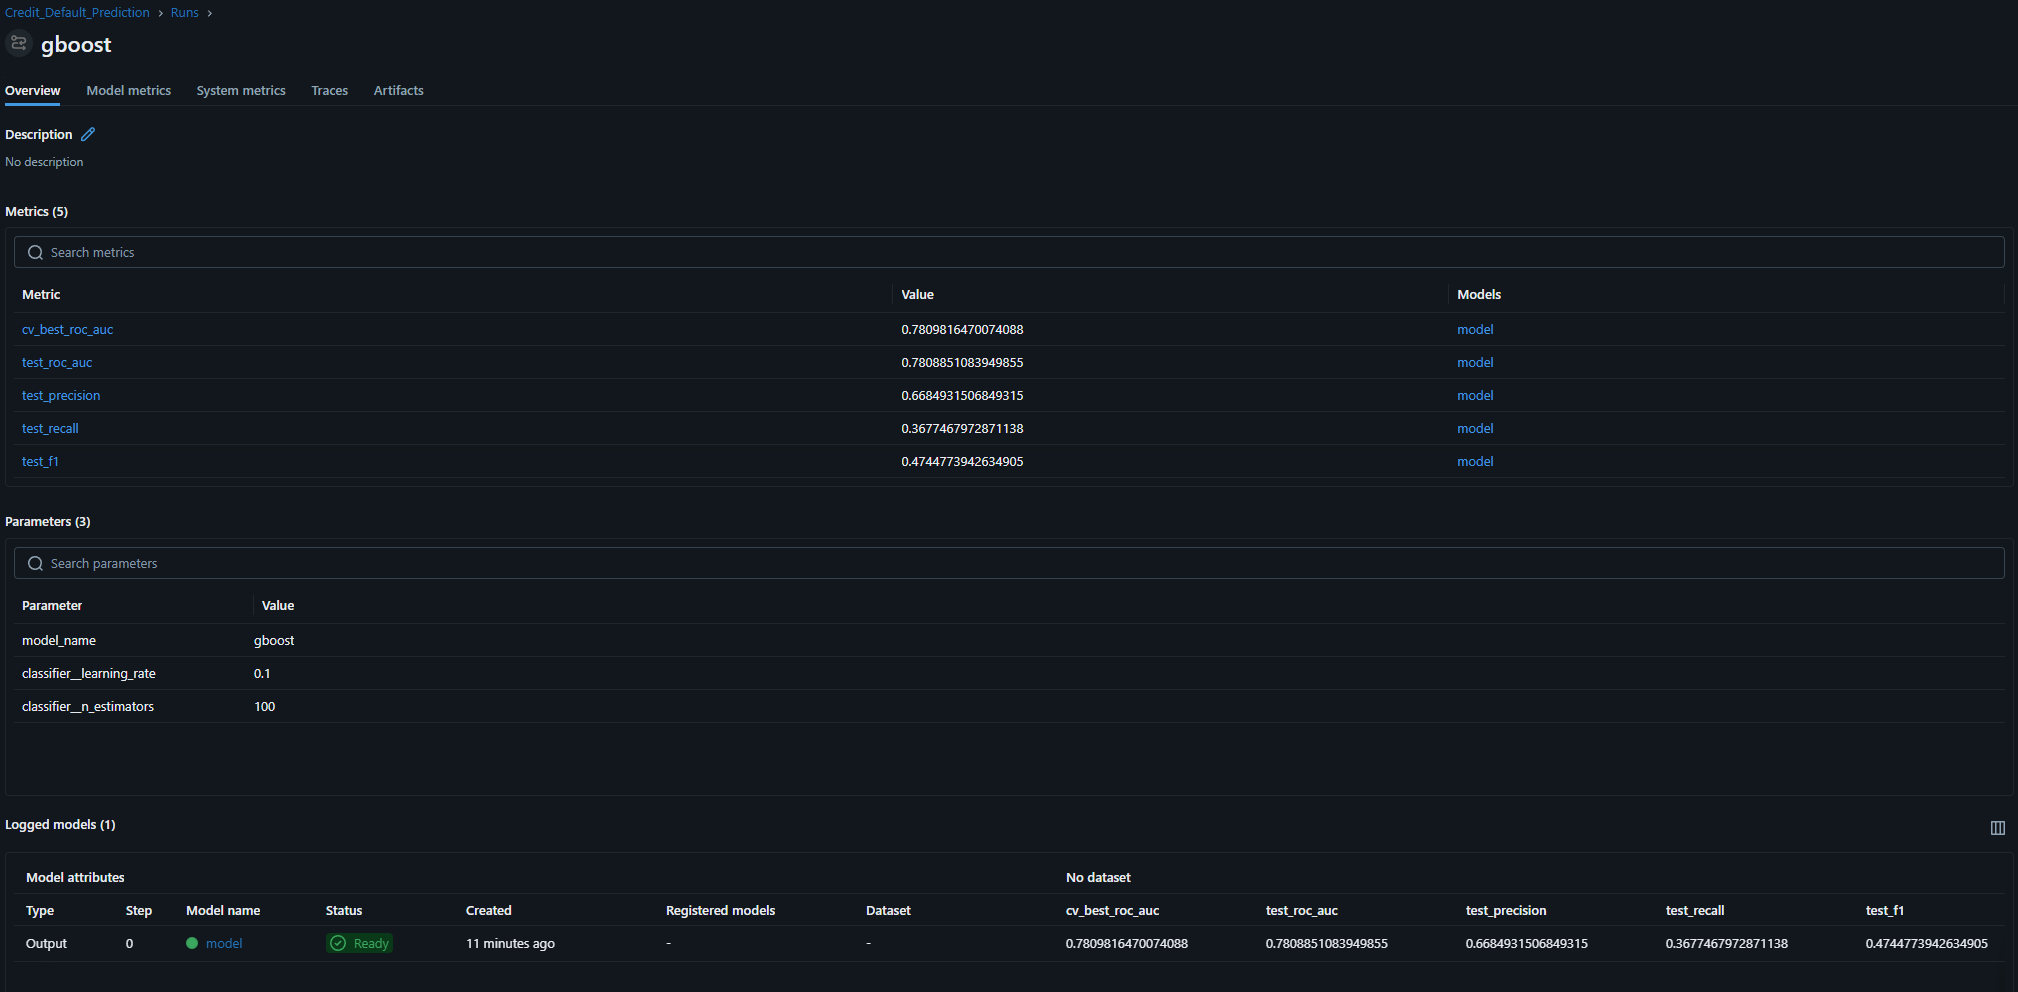

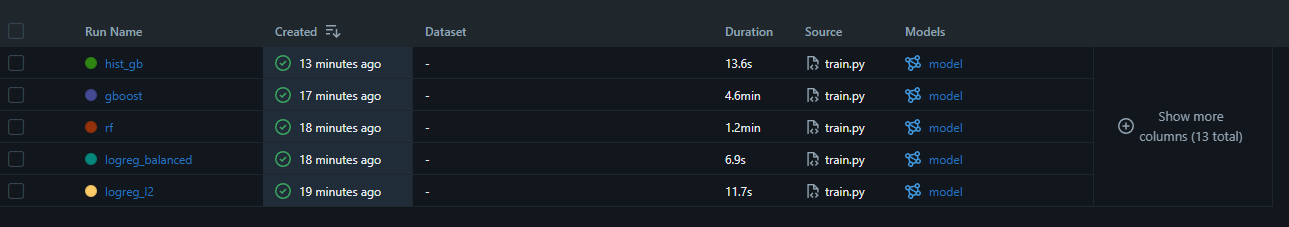

#DVC pipeline: dvc.yaml

In [ ]:
%%writefile credit-scoring-model/dvc.yaml
stages:
  prepare:
    cmd: python -m src.data.make_dataset
    deps:
      - src/data/make_dataset.py
      - src/data/validation.py
      - src/features/build_features.py
      - data/raw/UCI_Credit_Card.csv
    outs:
      - data/processed/train.csv
      - data/processed/test.csv

  train:
    cmd: python -m src.models.train
    deps:
      - src/models/train.py
      - src/models/pipeline.py
      - data/processed/train.csv
      - data/processed/test.csv
    outs:
      - models/credit_default_model.pkl
    metrics:
      - metrics.json:
          cache: false

#FastAPI

src/api/app.py

поднимает REST API /predict, возвращает класс и вероятность

In [ ]:
%%writefile credit-scoring-model/src/api/app.py

APP_TITLE = "Credit Default Prediction API"

app = FastAPI(title=APP_TITLE)

MODEL_PATH = os.environ.get("MODEL_PATH", "models/credit_default_model.pkl")
model = None


class ClientData(BaseModel):
    # сделаем базовый набор, но API примет и лишние поля через dict -> df (у нас строгая схема, так проще для оценки)
    LIMIT_BAL: float
    SEX: int
    EDUCATION: int
    MARRIAGE: int
    AGE: int
    PAY_0: int
    BILL_AMT1: float
    PAY_AMT1: float
    AGE_BIN: str = None  # если не передадут - ok


@app.on_event("startup")
def load_model():
    global model
    if not os.path.exists(MODEL_PATH):
        raise RuntimeError(f"Model not found: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)


@app.get("/")
def read_root():
    return {"message": "API is alive"}


@app.post("/predict")
def predict(data: ClientData):
    # переводим в df
    d = data.dict()
    df = pd.DataFrame([d])

    # если AGE_BIN не прислали - сделаем грубо
    if "AGE_BIN" not in df.columns or df["AGE_BIN"].isna().all():
        age = int(df.loc[0, "AGE"])
        if age < 25:
            df.loc[0, "AGE_BIN"] = "<25"
        elif age < 35:
            df.loc[0, "AGE_BIN"] = "25-35"
        elif age < 45:
            df.loc[0, "AGE_BIN"] = "35-45"
        elif age < 55:
            df.loc[0, "AGE_BIN"] = "45-55"
        elif age < 65:
            df.loc[0, "AGE_BIN"] = "55-65"
        else:
            df.loc[0, "AGE_BIN"] = "65+"

    proba = float(model.predict_proba(df)[:, 1][0])
    pred = int(proba >= 0.5)

    return {"default_prediction": pred, "default_probability": proba}

#Мониторинг PSI

берёт часть теста как “новые данные”

шлёт в API

сравнивает распределение вероятностей (train vs new) через PSI

src/models/predict.py

In [ ]:
%%writefile credit-scoring-model/src/models/predict.py

TARGET_COL = "default.payment.next.month"


def predict_proba_batch(model_path: str, data_path: str):
    model = joblib.load(model_path)
    df = pd.read_csv(data_path)
    if TARGET_COL in df.columns:
        X = df.drop(columns=[TARGET_COL])
    else:
        X = df
    return model.predict_proba(X)[:, 1]

In [ ]:
%%writefile credit-scoring-model/src/api/drift_monitor.py

TARGET_COL = "default.payment.next.month"


def psi(expected: np.ndarray, actual: np.ndarray, buckets: int = 10, eps: float = 1e-6) -> float:
    """
    PSI для сравнения распределений.
    expected - "старое" (например train)
    actual - "новое" (например online)
    """
    expected = np.asarray(expected)
    actual = np.asarray(actual)

    # бины по квантилям expected
    quantiles = np.linspace(0, 1, buckets + 1)
    cuts = np.quantile(expected, quantiles)
    cuts[0] = -np.inf
    cuts[-1] = np.inf

    e_perc, _ = np.histogram(expected, bins=cuts)
    a_perc, _ = np.histogram(actual, bins=cuts)

    e_perc = e_perc / max(len(expected), 1)
    a_perc = a_perc / max(len(actual), 1)

    # защищаемся от нулей
    e_perc = np.clip(e_perc, eps, 1.0)
    a_perc = np.clip(a_perc, eps, 1.0)

    value = np.sum((a_perc - e_perc) * np.log(a_perc / e_perc))
    return float(value)


def send_rows_to_api(df: pd.DataFrame, api_url: str, n: int = 200) -> np.ndarray:
    """
    Берём n строк и отправляем на API, собираем вероятности.
    """
    probs = []
    df_small = df.sample(n=min(n, len(df)), random_state=42)

    for _, row in df_small.iterrows():
        payload = {
            "LIMIT_BAL": float(row.get("LIMIT_BAL", 0.0)),
            "SEX": int(row.get("SEX", 1)),
            "EDUCATION": int(row.get("EDUCATION", 1)),
            "MARRIAGE": int(row.get("MARRIAGE", 1)),
            "AGE": int(row.get("AGE", 30)),
            "PAY_0": int(row.get("PAY_0", 0)),
            "BILL_AMT1": float(row.get("BILL_AMT1", 0.0)),
            "PAY_AMT1": float(row.get("PAY_AMT1", 0.0)),
            "AGE_BIN": row.get("AGE_BIN", None),
        }

        r = requests.post(f"{api_url}/predict", json=payload, timeout=10)
        r.raise_for_status()
        probs.append(r.json()["default_probability"])

    return np.array(probs)


def main(
    train_path="data/processed/train.csv",
    test_path="data/processed/test.csv",
    api_url="http://127.0.0.1:8000",
):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # baseline: вероятности на train и на "новых" данных через API
    # (в реале baseline лучше фиксировать и хранить)
    from src.models.predict import predict_proba_batch
    train_probs = predict_proba_batch("models/credit_default_model.pkl", train_path)

    # новые данные берём из теста и шлём в API
    actual_probs = send_rows_to_api(test_df.drop(columns=[TARGET_COL]), api_url=api_url, n=200)

    v = psi(train_probs, actual_probs, buckets=10)
    print("PSI(probabilities) =", v)

    # простая интерпретация
    if v < 0.1:
        print("Дрифт слабый (примерно ок)")
    elif v < 0.25:
        print("Есть заметный дрифт (надо смотреть)")
    else:
        print("Сильный дрифт (почти точно проблема)")


if __name__ == "__main__":
    main()

#Тесты + проверка GE

unit-тест на фичи

In [ ]:
%%writefile credit-scoring-model/tests/test_features.py

def test_add_features_creates_columns():
    df = pd.DataFrame({
        "AGE": [20, 40],
        "PAY_0": [0, 1],
        "PAY_2": [0, 0],
        "BILL_AMT1": [100.0, 200.0],
        "BILL_AMT2": [50.0, 70.0],
        "PAY_AMT1": [10.0, 20.0],
        "PAY_AMT2": [0.0, 5.0],
    })
    out = add_features(df)
    assert "AGE_BIN" in out.columns
    assert "PAY_mean" in out.columns
    assert "BILL_sum" in out.columns
    assert "PAYAMT_sum" in out.columns

Fail если target имеет неправильные значения

In [ ]:
%%writefile credit-scoring-model/tests/test_validation.py

def test_validation_fails_on_bad_target():
    df = pd.DataFrame({
        "LIMIT_BAL": [10000, 20000],
        "AGE": [30, 40],
        "SEX": [1, 2],
        "EDUCATION": [1, 2],
        "MARRIAGE": [1, 2],
        "default.payment.next.month": [0, 2],  # 2 нельзя, должно упасть
    })

    with pytest.raises(Exception):
        validate_df(df)

тест метрики

In [ ]:
%%writefile credit-scoring-model/tests/test_metrics.py



def test_roc_auc_basic():
    y_true = np.array([0, 0, 1, 1])
    y_score = np.array([0.1, 0.4, 0.6, 0.9])
    v = roc_auc_score(y_true, y_score)
    assert v > 0.9

проверка что тесты проходят

In [ ]:
!cd credit-scoring-model && pytest -q